This notebook peforms Villarubia's blind tip reconstruction from noisy image data

## load required packages and test data

In [1]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Random
using Statistics
using Revise, MDToolbox

In [2]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip nx ny surfs images images_randn

## Blind-tip reconstruction from noisy Image

In [3]:
nframe = 5
nrealization = 100

T = [0.1, 1.0, 10.0, 20.0, 40.0, 80.0]
loss_over_lambdas_array = []
P_over_lambdas_array = []

Random.seed!(777);

for irealization = 1:nrealization
    @info irealization

    for iframe = 1:length(images)
        images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
    end

    P_over_lambdas = []
    loss_over_lambdas = []

    for t in T
        m_P = similar(tip)
        m_P .= 0.0

        itip_estimate!(m_P, images_randn[1:nframe], thresh=t);

        loss = 0.0
        for image in images_randn[1:nframe]
            loss += mean((idilation(ierosion(image, m_P), m_P) .- image).^2)
        end
        loss = loss / length(images_randn[1:nframe])
        
        push!(P_over_lambdas, m_P)
        push!(loss_over_lambdas, loss)
    end
    
    push!(P_over_lambdas_array, P_over_lambdas)
    push!(loss_over_lambdas_array, loss_over_lambdas)
end

Processed 5 image
26 refinements 
Processed 5 image
26 refinements 
Processed 5 image
47 refinements 
Processed 5 image
33 refinements 
Processed 5 image
15 refinements 
Processed 5 image
5 refinements 
Processed 5 image
31 refinements 
Processed 5 image
31 refinements 
Processed 5 image
50 refinements 
Processed 5 image
25 refinements 
Processed 5 image
14 refinements 
Processed 5 image
5 refinements 
Processed 5 image
32 refinements 
Processed 5 image
29 refinements 
Processed 5 image
60 refinements 
Processed 5 image
20 refinements 
Processed 5 image
15 refinements 
Processed 5 image
5 refinements 
Processed 5 image
43 refinements 
Processed 5 image
36 refinements 
Processed 5 image
66 refinements 
Processed 5 image
37 refinements 
Processed 5 image
17 refinements 
Processed 5 image
4 refinements 
Processed 5 image
38 refinements 
Processed 5 image
38 refinements 
Processed 5 image
60 refinements 
Processed 5 image
30 refinements 
Processed 5 image
20 refinements 
Processed 5 image


┌ Info: 1
└ @ Main In[3]:11
┌ Info: 2
└ @ Main In[3]:11
┌ Info: 3
└ @ Main In[3]:11
┌ Info: 4
└ @ Main In[3]:11
┌ Info: 5
└ @ Main In[3]:11
┌ Info: 6
└ @ Main In[3]:11
┌ Info: 7
└ @ Main In[3]:11
┌ Info: 8
└ @ Main In[3]:11
┌ Info: 9
└ @ Main In[3]:11
┌ Info: 10
└ @ Main In[3]:11
┌ Info: 11
└ @ Main In[3]:11
┌ Info: 12
└ @ Main In[3]:11
┌ Info: 13
└ @ Main In[3]:11
┌ Info: 14
└ @ Main In[3]:11
┌ Info: 15
└ @ Main In[3]:11
┌ Info: 16
└ @ Main In[3]:11
┌ Info: 17
└ @ Main In[3]:11
┌ Info: 18
└ @ Main In[3]:11
┌ Info: 19
└ @ Main In[3]:11
┌ Info: 20
└ @ Main In[3]:11
┌ Info: 21
└ @ Main In[3]:11
┌ Info: 22
└ @ Main In[3]:11
┌ Info: 23
└ @ Main In[3]:11
┌ Info: 24
└ @ Main In[3]:11
┌ Info: 25
└ @ Main In[3]:11
┌ Info: 26
└ @ Main In[3]:11
┌ Info: 27
└ @ Main In[3]:11
┌ Info: 28
└ @ Main In[3]:11
┌ Info: 29
└ @ Main In[3]:11
┌ Info: 30
└ @ Main In[3]:11
┌ Info: 31
└ @ Main In[3]:11
┌ Info: 32
└ @ Main In[3]:11
┌ Info: 33
└ @ Main In[3]:11
┌ Info: 34
└ @ Main In[3]:11
┌ Info: 35
└ @ Main In[

In [4]:
gr()

Plots.GRBackend()

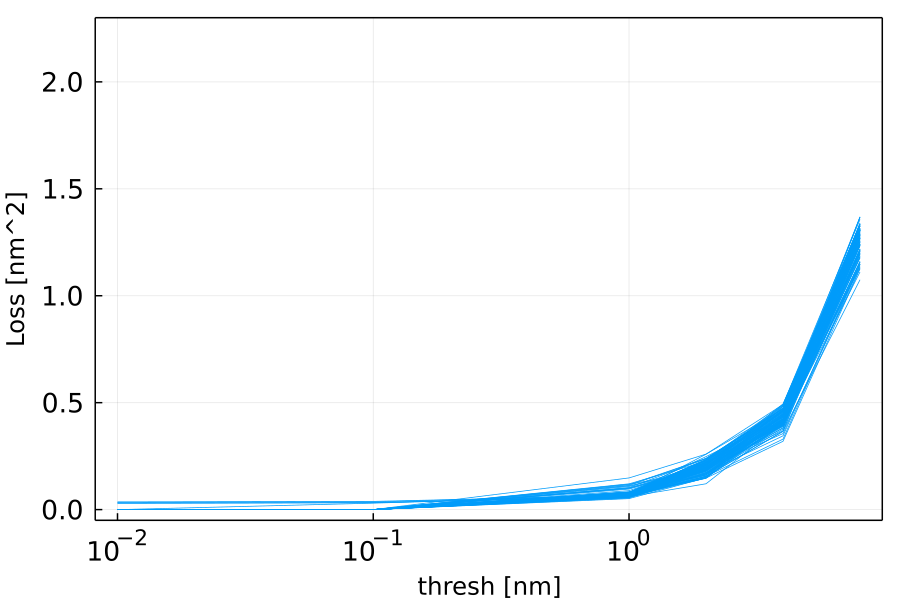

In [5]:
plot(T ./ 10.0, loss_over_lambdas_array[1] / 100.0, xaxis=:log, framestyle=:box, 
     xlabel="theresh [nm]", ylabel="loss [nm^2]", label=nothing, linewidth=0.5, dpi=150, fmt=:png, color=1, 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

l_mean = deepcopy(loss_over_lambdas_array[1] ./ 100.0)
for i = 2:nrealization
    plot!(T ./ 10.0, loss_over_lambdas_array[i] ./ 100.0, xaxis=:log, framestyle=:box, 
          xlabel="thresh [nm]", ylabel="loss [nm^2]", 
          label=nothing, linewidth=0.5, dpi=150, fmt=:png, color=1)
    l_mean .+= (loss_over_lambdas_array[i] ./ 100.0)
end
l_mean .= l_mean ./ nrealization

l_std = deepcopy(l_mean)
l_std .= 0.0
for i = 1:nrealization
    l_std .+= ((loss_over_lambdas_array[i] ./ 100.0) .- l_mean).^2
end
l_std .= l_std ./ (nrealization - 1.0)

#plot!(lambdas, l_mean, ribbon=l_std, fillalpha=0.5, color=1, linewidth=0.0, legend=nothing)

ylims!(-0.05, 2.3)
xlabel!("thresh [nm]", fontsize=35)
p = ylabel!("Loss [nm^2]", fontsize=35)

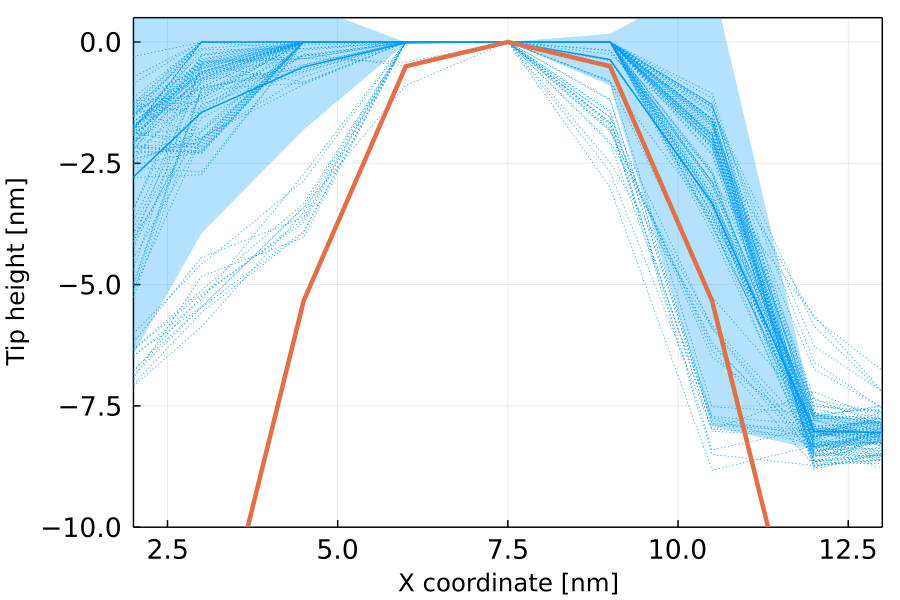

In [6]:
it = 5
islice = 5
cutoff = 80.0

plot(collect(1:nx) .* resolution ./ 10.0, P_over_lambdas_array[1][it][islice, :] / 10.0, linewidth=0.5, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
p_mean = deepcopy(P_over_lambdas_array[1][it][islice, :] ./ 10.0)
for irealization = 2:nrealization
    plot!(collect(1:nx) .* resolution ./ 10.0, P_over_lambdas_array[irealization][it][islice, :] / 10.0, linewidth=0.5, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    p_mean .+= P_over_lambdas_array[irealization][it][islice, :] ./ 10.0
end
p_mean .= p_mean ./ nrealization

p_std = deepcopy(p_mean)
p_std .= 0.0
for irealization = 1:nrealization
    p_std .+= (P_over_lambdas_array[irealization][it][islice, :] ./ 10.0 .- p_mean).^2
end
p_std .= p_std ./ (nrealization - 1.0)

plot!(collect(1:nx) .* resolution ./ 10.0, p_mean, ribbon=p_std, fillalpha=0.3, color=1)

plot!((collect(1:nx)) .* resolution ./ 10.0, tip[islice, :] ./ 10.0, linewidth=3, label="ground truth", legend=nothing, color=2, 
      xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

ylims!((-10, 0.5))
xlims!((2, 13))
xlabel!("X coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

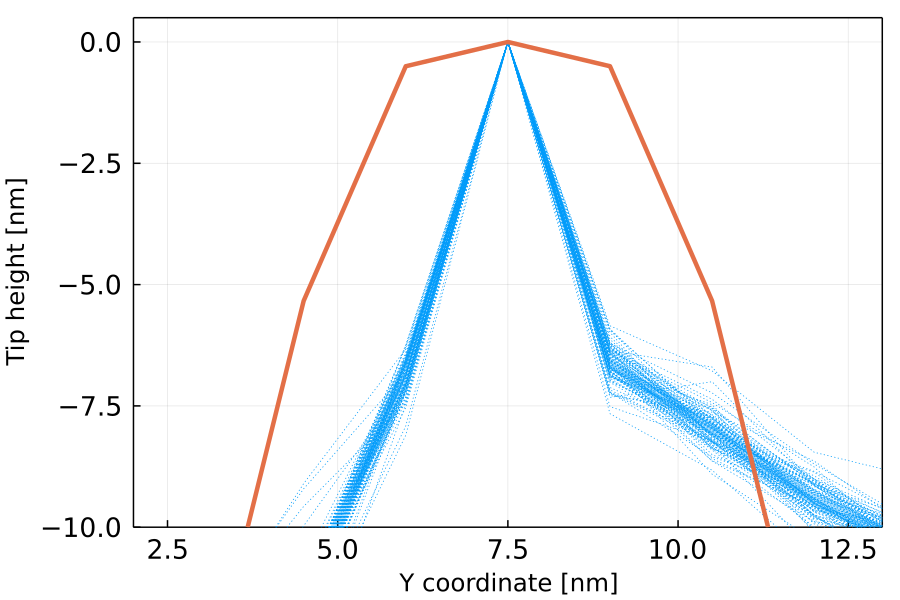

In [7]:
it = 1
islice = 5

plot(collect(1:ny) .* resolution ./ 10.0, P_over_lambdas_array[1][it][:, islice] / 10.0, 
    linewidth=0.5, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
p_mean = deepcopy(P_over_lambdas_array[1][it][:, islice] ./ 10.0)
for irealization = 2:nrealization
    plot!(collect(1:ny) .* resolution / 10.0, P_over_lambdas_array[irealization][it][:, islice] ./ 10.0, 
        linewidth=0.5, linestyle=:dot, color=1, label=nothing, framestyle=:box, dpi=150, fmt=:png, legend=nothing)
    p_mean .+= P_over_lambdas_array[irealization][it][:, islice] ./ 10.0
end
p_mean .= p_mean ./ nrealization

p_std = deepcopy(p_mean)
p_std .= 0.0
for irealization = 1:nrealization
    p_std .+= (P_over_lambdas_array[irealization][it][:, islice] ./ 10.0 .- p_mean).^2
end
p_std .= p_std ./ (nrealization - 1.0)

plot!(collect(1:ny) .* resolution ./ 10.0, p_mean, ribbon=p_std, fillalpha=0.3, color=1, linewidth=0.0)

plot!((collect(1:ny)) .* resolution ./ 10.0, tip[:, islice] / 10.0, linewidth=3, label="ground truth", legend=nothing, color=2, 
      xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

ylims!((-10, 0.5))
xlims!((2, 13))

xlabel!("Y coordinate [nm]", fontsize=35)
p = ylabel!("Tip height [nm]", fontsize=35)

In [8]:
pyplot()

Plots.PyPlotBackend()

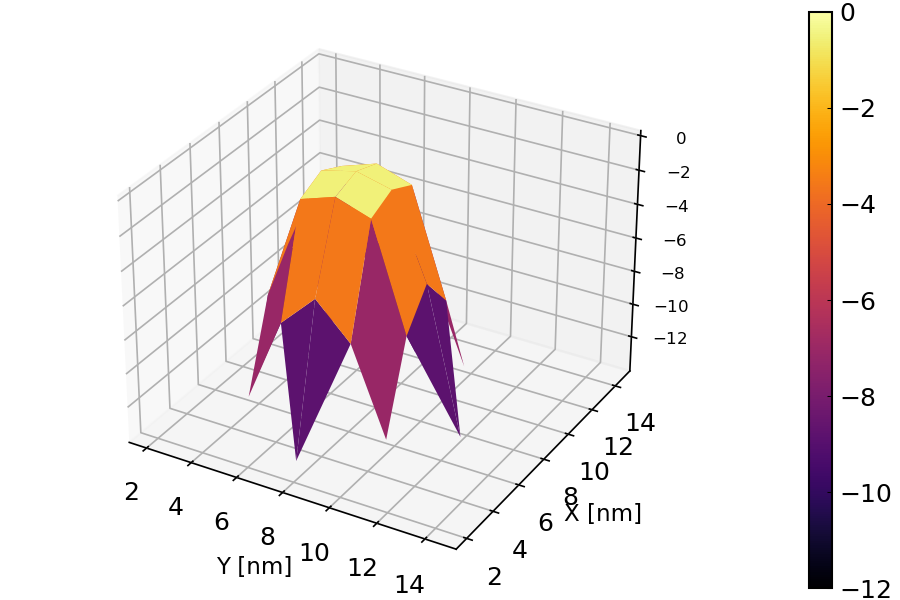

In [9]:
tip_tmp = deepcopy(tip)
tip_tmp[tip .< -150.0] .= NaN

plot(collect(1:nx) .* resolution ./ 10.0, collect(1:ny) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0),
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

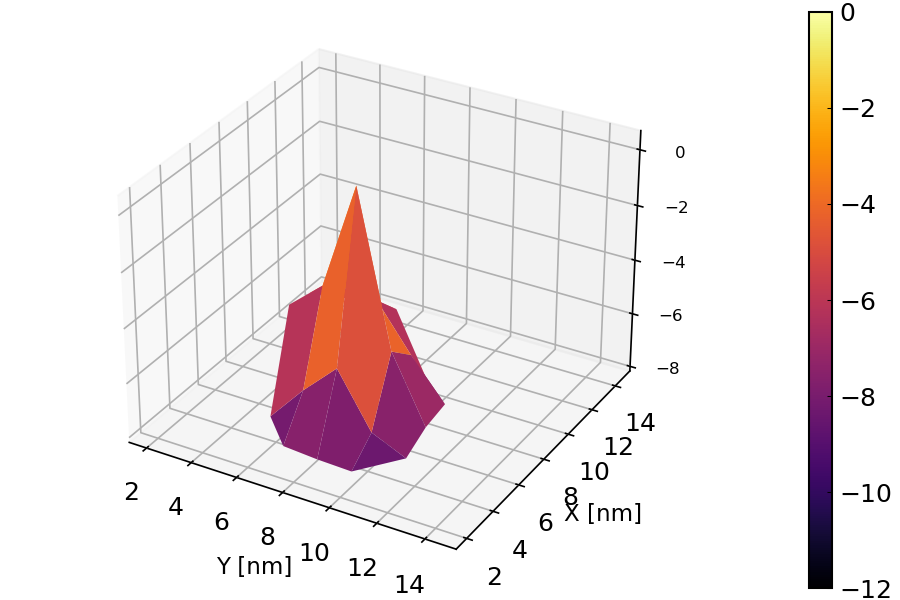

In [10]:
tip_tmp = deepcopy(P_over_lambdas_array[1][3])
tip_tmp[tip .< -120.0] .= NaN

plot(collect(1:nx) .* resolution ./ 10.0, collect(1:ny) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, clim=(-12, 0), 
     xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
zlims!((-8, 0.5))
xlabel!("Y [nm]", fontsize=35)
p = ylabel!("X [nm]", fontsize=35)
#zlabel!("Tip height [nm]", fontsize=35)

In [11]:
gr()

Plots.GRBackend()

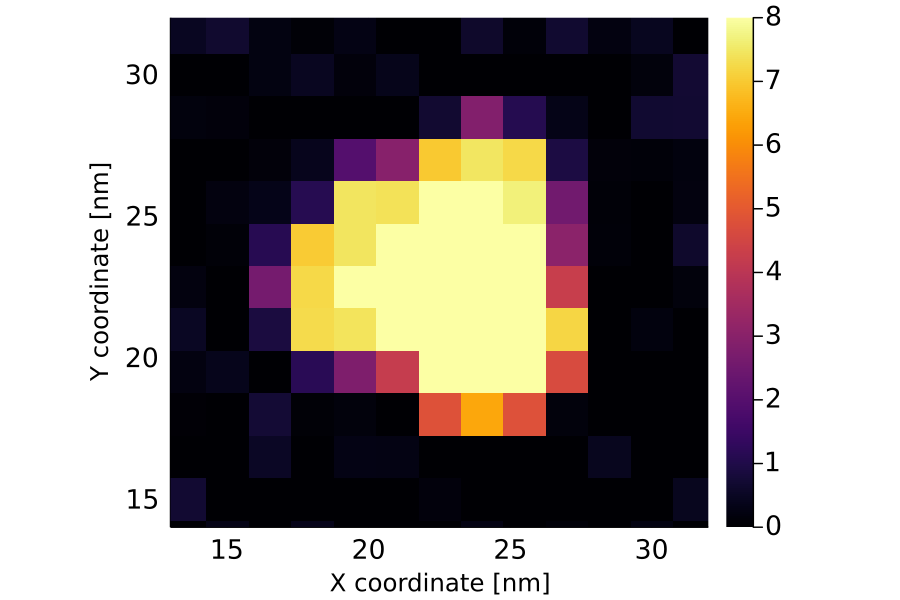

In [12]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images_randn[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png, aspect_ratio=:equal, 
    xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

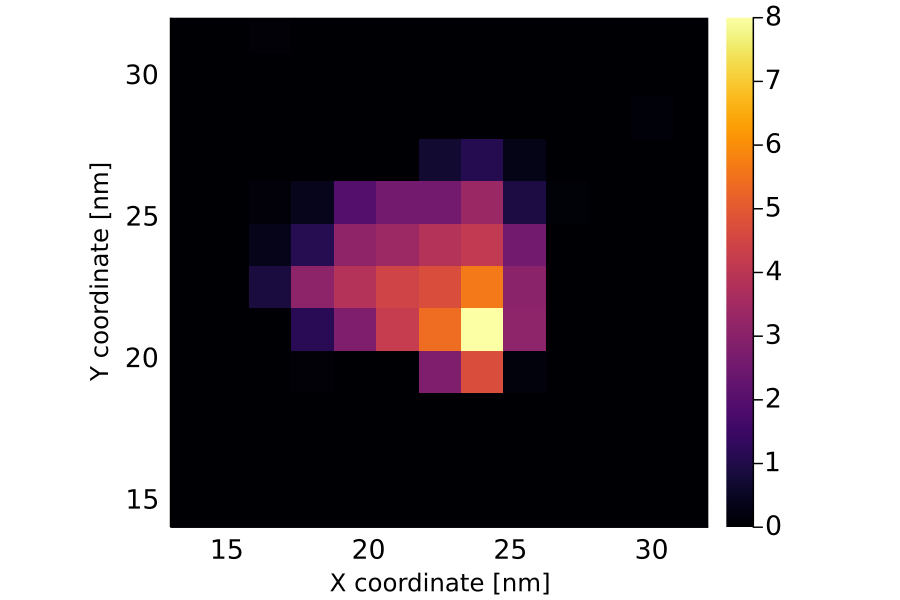

In [13]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images_randn[1], P_over_lambdas_array[1][4]) / 10.0, clim=(0, 8), dpi=150, fmt=:png, aspect_ratio=:equal,
    xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

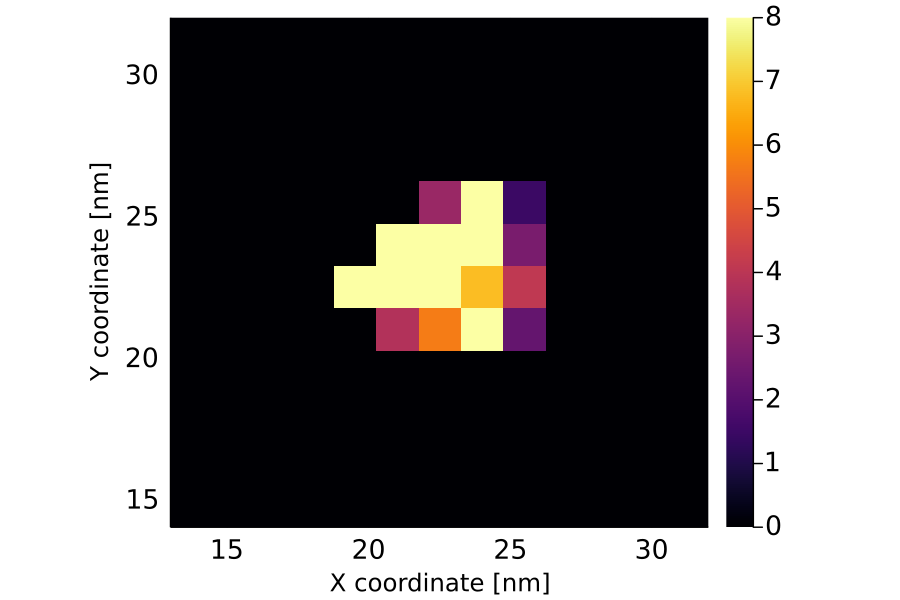

In [14]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, surfs[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png, aspect_ratio=:equal, 
            xtickfontsize=12, ytickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(13, 32)
ylims!(14, 32)

# Pixel RMSD of reconstructed tip

In [15]:
function pixel_rmsd(image1, image2, ref; cutoff = -70.0)
    image1_shifted = similar(image1)

    rmsd_min = Inf64
    for du = -5:5, dv = -5:5
        image1_shifted = circshift(image1, (du, dv))
        #id = (image1_shifted .> cutoff) .| (image2 .> cutoff)
        id = ref .> cutoff
        tmp = sqrt(mean((image1_shifted[id] .- image2[id]).^2))
        if tmp < rmsd_min
            rmsd_min = tmp
        end
    end
    return rmsd_min
end

diff_tip = zeros(Float64, length(T)*nrealization, 2)
count = 0
for it = 1:length(T)
    for ireal = 1:nrealization
        c = pixel_rmsd(P_over_lambdas_array[ireal][it], tip, tip, cutoff=-80.0)
        count += 1
        diff_tip[count, 1] = T[it]
        diff_tip[count, 2] = c
    end
end

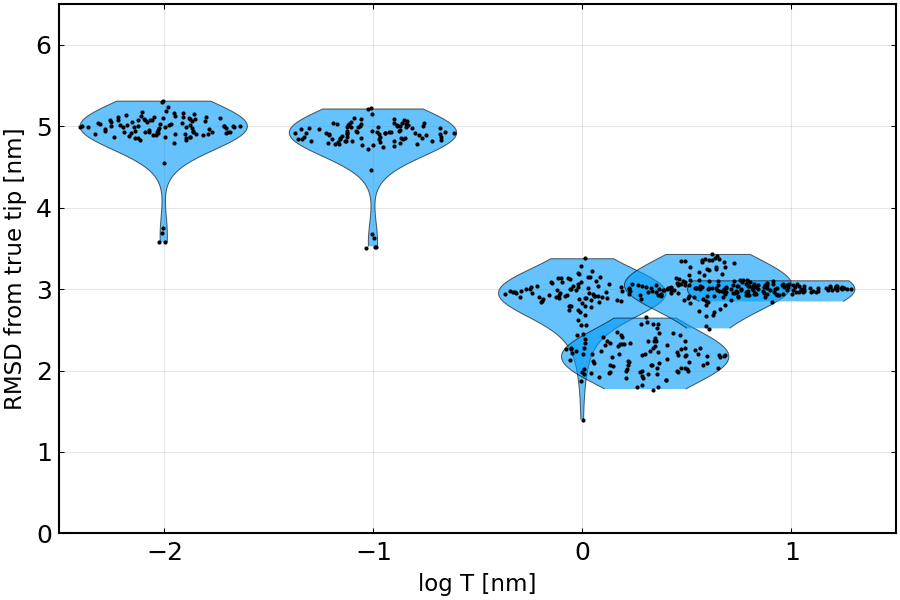

In [16]:
using StatsPlots
pyplot()

violin(log10.(diff_tip[:, 1] ./ 10.0), diff_tip[:, 2] ./ 10.0, 
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=1)

dotplot!(log10.(diff_tip[:, 1] ./ 10.0), diff_tip[:, 2] ./ 10.0, marker=(:black,stroke(0)), mode = :density, markersize=2.0, label=nothing)

#scatter(diff_tip[:, 1] / 10.0, diff_tip[:, 2] / 10.0, xaxis=:log, framestyle = :box, xlabel="threshold T", ylabel="RMSD frome true tip [nm]", label=nothing, linewidth=1.0, markershape=:circle, dpi=150, fmt=:png, color=1, 
#        xtickfontsize=12, ytickfontsize=12, legendfontsize=10, colorbar_tickfontsize=10, markersize=12, markerstrokewidth=1)
#ylims!(-0.05, 2.3)
xlabel!("log T [nm]", fontsize=35)
p = ylabel!("RMSD from true tip [nm]", fontsize=35)
xlims!(-2.5, 1.5)
ylims!(0.0, 6.5)

# Pixel RMSD of reconstructed surface

In [17]:
diff_surf = zeros(Float64, length(T)*nrealization*nframe, 2)
count = 0
Random.seed!(777);
images_randn = deepcopy(images)

for it = 1:length(T)
    for ireal = 1:nrealization
        for iframe = 1:nframe
            images_randn[iframe] .= images[iframe] .+ 3.0 .* randn(Float64, size(images[iframe]))
            c = pixel_rmsd(ierosion(images_randn[iframe], P_over_lambdas_array[ireal][it]), surfs[iframe], images[iframe], cutoff=10.0)
            count += 1
            diff_surf[count, 1] = T[it]
            diff_surf[count, 2] = c
        end
    end
end

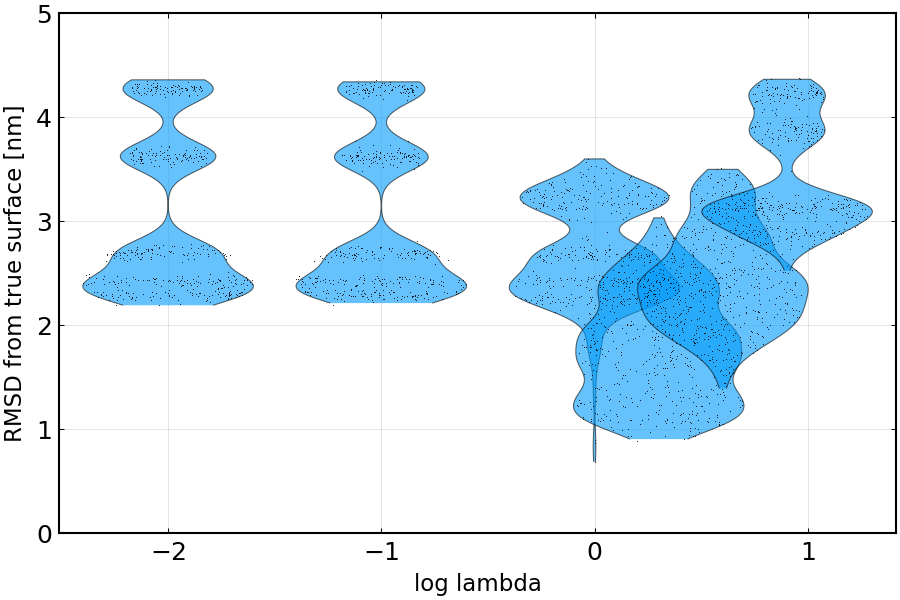

In [18]:
using StatsPlots
pyplot()

violin(log10.(diff_surf[:, 1] ./ 10.0), diff_surf[:, 2] / 10.0, ylim=(-0.1, 6.0),
       xtickfontsize=12, ytickfontsize=12, legendfontsize=12, 
       xlabel="log lambda", ylabel="RMSD from true surface [nm]", 
       framestyle=:box, label=nothing, linewidth=0.5, dpi=150, fmt=:png, alpha=0.6, color=1)

dotplot!(log10.(diff_surf[:, 1] ./ 10.0), diff_surf[:, 2] / 10.0, marker=(:black, stroke(0)), markersize=0.5, mode = :density, label=nothing)

ylims!(-0.0, 5)

# Save results

In [19]:
using BSON: @save, @load

@save "original_$(nframe).bson" tip images nframe nrealization T P_over_lambdas_array diff_tip diff_surf 